# Mineração - Aula 02

## Relatório sobre análise de reclamações

### Enunciado:
Utilizando o framework de análise descrito na aula passada e as técnicas de visualização apropriadas, faça uma análise sobre o dataset de reclamações do procon (link em anexo).
Eu quero saber quais empresas são mais odiadas.

Você deve entregar UM notebook jupyter com o relatório da sua análise. É para fazer descrições e visualizações, nada de fazer um monte de gráficos de qualquer jeito. Também não seja um robô, faça um relatório descrevendo seus pontos, os motivos que levam você a analisar ou concluir algo. Pense em setores, tipos de produtos, ... ou qualquer coisa que melhore meu entendimento sobre o problema. 

Assuma que sou uma besta acéfala que mal sabe ler (você não vai estar tão errado). Faça descrições cuidadosas e em "linguage humana".

### Dados:
https://www.kaggle.com/gerosa/procon/data e http://dados.gov.br/dataset/cadastro-nacional-de-reclamacoes-fundamentadas-procons-sindec1

#### Dicionario de dados:
http://dados.mj.gov.br/dataset/8ff7032a-d6db-452b-89f1-d860eb6965ff/resource/d87543d6-cf9d-4752-8f3c-1b0aa075dc45/download/dicionariodadossindec3-0.pdf

- Ano calendário de publicação do cadastro de reclamações fundamentadas:

|Ano |reclamações fundamentadas|arquivadas entre|Número de Procons estaduais/municipais|
|:--:|:-----------------------:|:---------------:|:---:|
|2009|104.867                  |09/2008 e 08/2009|39   |
|2010|122.662                  |09/2009 e 08/2010|52   |
|2011|153.094                  |01/2011 e 12/2011|67   |
|2012|211.076                  |01/2012 e 12/2012|112  |

- Os arquivos de dados do PROCON de 2009 a 2016 foram copiados para uma pasta Dropbox para poderem ser baixados automaticamente durante a execução do código. Na primeira vez que se executa o código, todos os arquivos são baixados, consolidados e salvos em um arquivo pickle. O arquivo pickle será utilizado nas futuras execuções com o objetivo de economizar tempo pois evita baixar os arquivos do PROCON novamente.

- RadicalCNPJ: Aplica-se para pessoa jurídica e serve para agrupar as informações de um mesmo fornecedor (matriz e filiais), sendo os oitos primeiros dígitos do número do CNPJ - Exemplo: a matriz (central) do banco e suas filiais (agências)

- Faixa etária do consumidor distribuída da seguinte forma: até 20 anos, entre 21 e 30 anos, entre 31 e 40 anos, entre 41 e 50 anos, entre 51 e 60 anos, entre 61 e 70 anos, mais de 70 anos, Nao Informada (data de nascimento não informada no cadastro do consumidor), Não se aplica (são as reclamações (de ofício) em que o Procon é o reclamante)


### Passo 00 - Discussão e delineamento do Problema

Pergunta principal: Quais são as empresas mais odiadas?

Por "empresas mais odiadas" entendemos que são as empresas com as menores taxas de atendimento das reclamações, dentre as 500 com mais reclamações no PROCON desde 2013. Analisaremos também se a frequência de reclamações é sazonal ao longo do ano, se é maior em algumas regiões ou estados (em termos absolutos e relativos) e se o tempo até a resolução da reclamação varia ao longo do tempo e por setor.

Este relatório foi dividio nos seguintes passos:
- 1 - Abertura dos arquivos de dados
- 2 - Organização, padronização e limpeza dos dados
- 3 - Pré análise
- 4 - Geração dos gráficos principais
- 5 - Conslusões


### Passo 01 - Abrindo os arquivos com os dados a serem utilizados

In [1]:
## importanto bibliotecas
from urllib.request import urlopen
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

## Configurações padrão
%cd C://_kopp//Dropbox//Filipe//_doutorado//Mineracao
pd.options.display.float_format = '{:.1f}'.format
plt.style.use('seaborn')  #plt.style.available
size = (10,6)

[WinError 2] O sistema não pode encontrar o arquivo especificado: 'C://_kopp//Dropbox//Filipe//_doutorado//Mineracao'
C:\_kopp\Dropbox\Filipe\_doutorado\PPGI\MINERACAO


In [2]:
## Dados de população de cada UF serão usados para normalizar algumas análises.
## source: https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o
populacao = {'AC': 831473, 'AL': 3378287, 'AP': 800567, 'AM': 4072343, 'BA': 15355449, 'CE': 9033796, 'DF': 3046233,
             'ES': 4019390, 'GO': 6792817, 'MA': 7004330, 'MT': 3350247, 'MS': 2718195, 'MG': 21140120, 'PA': 8377844,
             'PB': 4028416, 'PR': 11335726, 'PE': 9483440, 'PI': 3220991, 'RJ': 16736365, 'RN': 3512714, 'RS': 11333417,
             'RO': 1808986, 'RR': 524681, 'SC': 6994566, 'SP': 45162700, 'SE': 2292102, 'TO': 1553026}
pop  = pd.DataFrame.from_dict(populacao, orient='index')
print('população do Brasil:',sum(populacao.values()))

população do Brasil: 207908221


In [3]:
## Baixando os arquivos
urls = ['https://www.dropbox.com/s/lxq41kw10jwum6k/reclamacoes-fundamentadas-sindec-2009.csv?dl=1',
        'https://www.dropbox.com/s/48u53comem6vfqv/reclamacoes-fundamentadas-sindec-2010.csv?dl=1',
        'https://www.dropbox.com/s/ddsq2d9luyrelvd/reclamacoes-fundamentadas-sindec-2011.csv?dl=1',
        'https://www.dropbox.com/s/e9meajkvg3rb34v/reclamacoes-fundamentadas-sindec-2012.csv?dl=1',
        'https://www.dropbox.com/s/r89wzb1hmqyrzk7/reclamacoes-fundamentadas-sindec-2013.csv?dl=1',
        'https://www.dropbox.com/s/dcwtb62shu6zpws/reclamacoes-fundamentadas-sindec-2014.csv?dl=1',
        'https://www.dropbox.com/s/hsocwtkp53hon67/reclamacoes-fundamentadas-sindec-2015.csv?dl=1',
        'https://www.dropbox.com/s/4jx1g3aoze4lxmm/reclamacoes-fundamentadas-sindec-2016.csv?dl=1'] 
if os.path.isfile('reclama.pickle'):
    ## Se o arquivo pickle já existe, abrí-lo.
    print('pegando dados salvos no pickle')
    pd_reclama = pd.read_pickle('reclama.pickle')
else:
    ## Senão, baixar tudo e salvar em arquivo pickle.
    deli = 0
    pd_reclama = pd.DataFrame([])
    for url in urls:
        reclama_csv = urlopen(url)
        print('baixando dados de: ',url, end=' -> ')
        if deli < 3 : delim=';'
        else: delim = ','
        reclama_data = pd.read_csv(reclama_csv,delimiter=delim, dtype={0: str, 'NumeroCNPJ': str, 'RadicalCNPJ': str,
                                                                       'numeroCNPJ': str, 'radicalCNPJ': str,
                                                                       'CEPConsumidor': str}) 
        if deli < 3 : 
            reclama_data.rename(columns={'codigoregiao': 'CodigoRegiao','anocalendario': 'AnoCalendario',
                                         'radicalCNPJ': 'RadicalCNPJ', 'regiao': 'Regiao'}, inplace=True)
        deli += 1
        print(reclama_data.shape)
        pd_reclama = pd.concat([pd_reclama,reclama_data])
    pd_reclama.to_pickle('reclama.pickle')
print('total de linhas obtidas: ',pd_reclama.shape[0])
print('Arquivo pickle com ',int(os.stat('reclama.pickle').st_size/1024/1024)," MB.")

pegando dados salvos no pickle
total de linhas obtidas:  1586701
Arquivo pickle com  297  MB.


### Passo 02 - Organizando os dados

- Combinar colunas Razão Social com informações similares
- Normalizar a coluna Razão Social
- Diminuir tamaho das células em Faixa Etária

In [4]:
## Normalizando as Razões Sociais das empresas
pd_reclama['strRazaoSocial'].fillna(value=pd_reclama['RazaoSocialRFB'])
pd_reclama['strRazaoSocial'].fillna(value=pd_reclama['NomeFantasiaRFB'])
pd_reclama['strRazaoSocial'].fillna(value=pd_reclama['strNomeFantasia'])
pd_reclama['strRazaoSocial'] = pd_reclama['strRazaoSocial'].str.replace('[^\w\s]',' ')
pd_reclama['strRazaoSocial'] = pd_reclama['strRazaoSocial'].str.replace('\s\s+' ,' ')
pd_reclama['strRazaoSocial'] = pd_reclama['strRazaoSocial'].str.replace(' S A' ,'')
pd_reclama['strRazaoSocial'] = pd_reclama['strRazaoSocial'].str.strip()
pd_reclama['strRazaoSocial'] = pd_reclama['strRazaoSocial'].str.upper()
pd_reclama['strRazaoSocial'] = pd_reclama['strRazaoSocial'].str.normalize('NFKD').str.encode('ascii', 
                                                                errors='ignore').str.decode('utf-8')
pd_reclama['FaixaEtariaConsumidor'] = pd_reclama['FaixaEtariaConsumidor'].str.replace('entre ','').str.replace(' anos','')

- Quebrar Data de Abertura e Data de Arquivamenteo em Ano e mês
- Calcular diferença entre datas em dias
- Criando variáveis binárias para sexo e atendimento
- Remover linhas sem CNPJ ou Razão Social. Remover reclamações que não são empresas (CPF).
- Remover colunas que não são mais usadas

In [5]:
## Ano da data de Arquivamento não é tão interessante quanto data de abertura da reclamação. Vamos trabalhar com ano e mês
## das duas datas e calcular a diferença entre elas em dias.
pd_reclama['DataAbertura'] = pd.to_datetime(pd_reclama['DataAbertura'],infer_datetime_format=True)
pd_reclama['ano_abertura'] = pd_reclama['DataAbertura'].dt.year
pd_reclama['mes_abertura'] = pd_reclama['DataAbertura'].dt.month
pd_reclama['DataArquivamento'] = pd.to_datetime(pd_reclama['DataArquivamento'],infer_datetime_format=True)
pd_reclama['diff'] = (pd_reclama['DataArquivamento'] - pd_reclama['DataAbertura']).dt.days

## Codificando Atendipmento para 0 ou 1, para posteriormente calcular a média
pd_reclama['atendimento_bin'] = (pd_reclama['Atendida'] == 'S')

## Mantendo somente as empresas e removendo colunas que não são mais necessárias
df_reclama = pd_reclama.copy()
df_reclama.drop(df_reclama[df_reclama.Tipo < 1].index, inplace=True) 
df_reclama.dropna(subset=['NumeroCNPJ','strRazaoSocial'], inplace=True)
df_reclama.drop(columns=['NomeFantasiaRFB', 'RazaoSocialRFB','CodigoRegiao','CodigoAssunto','AnoCalendario','DataAbertura',
                         'DataArquivamento','CodigoProblema','Tipo','CEPConsumidor','CNAEPrincipal','strNomeFantasia'], 
                inplace=True)
print('total de linhas após limpeza: ',df_reclama.shape[0])
print('total de linhas removidas: ',pd_reclama.shape[0] - df_reclama.shape[0], ' ou ', 
      round((pd_reclama.shape[0] - df_reclama.shape[0])/pd_reclama.shape[0] *100,2) , '%')
df_reclama.sort_values('NumeroCNPJ', inplace=True)

total de linhas após limpeza:  1495388
total de linhas removidas:  91313  ou  5.75 %


In [6]:
## Deve-se criar um dataframe somente com o RadicalCNPJ e Razão Social, e remover as duplicatas do RadicalCNPJ, assim,
## obtém-se um nome para cada grupo empresarial (matriz e filial)
df_empresas = df_reclama[['RadicalCNPJ','strRazaoSocial']].copy()
df_empresas.dropna(subset=['RadicalCNPJ','strRazaoSocial'], inplace=True, how='any')
df_empresas.sort_values(['RadicalCNPJ','strRazaoSocial'], ascending=True, inplace=True)
df_empresas.drop_duplicates(subset=['RadicalCNPJ'], keep='first', inplace=True)
print('Foram obtidos',df_empresas.shape[0],'grupos empresariais distintos, através do Radical CNPJ')
df_resultado = pd.merge(df_reclama,df_empresas, on='RadicalCNPJ').sort_values(['RadicalCNPJ'])
df_resultado.rename(columns={'strRazaoSocial_y': 'razao','FaixaEtariaConsumidor': 'idade','SexoConsumidor': 'sexo'}, 
                    inplace=True)
df_resultado.drop(columns=['strRazaoSocial_x', 'NumeroCNPJ','RadicalCNPJ'], inplace=True)

Foram obtidos 80429 grupos empresariais distintos, através do Radical CNPJ


In [7]:
df_resultado.head(10)

,Regiao,UF,DescCNAEPrincipal,Atendida,DescricaoAssunto,DescricaoProblema,sexo,idade,ano_abertura,mes_abertura,diff,atendimento_bin,razao
0,Sudeste,ES,"BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL",N,Banco comercial,Cobrança indevida.,M,31 a 40,2011.0,2.0,55.0,False,BANCO BRASIL
9263,Centro-oeste,MT,BANCOS COMERCIAIS,S,Banco comercial,Cobrança indevida.,M,41 a 50,2009.0,4.0,112.0,True,BANCO BRASIL
9264,Centro-oeste,MT,BANCOS COMERCIAIS,S,Banco comercial,"Contrato (não cumprimento, alteração, transfer...",M,51 a 60,2016.0,2.0,279.0,True,BANCO BRASIL
9265,Centro-oeste,MT,BANCOS COMERCIAIS,S,Banco comercial,Calculo de prestação/taxa de juros,M,41 a 50,2015.0,8.0,80.0,True,BANCO BRASIL
9266,Centro-oeste,MT,BANCOS COMERCIAIS,S,Banco comercial,Cobrança indevida.,M,Nao Informada,2012.0,5.0,655.0,True,BANCO BRASIL
9267,Centro-oeste,MT,BANCOS COMERCIAIS,N,Cartão de Crédito,Não entrega do produto (titulo de capitalizaçã...,F,31 a 40,2012.0,9.0,627.0,False,BANCO BRASIL
9268,Centro-oeste,MT,BANCOS COMERCIAIS,S,Cartão de Crédito,Tarifa de Cartão de Crédito – Cobrança Indevid...,M,21 a 30,2012.0,4.0,703.0,True,BANCO BRASIL
9269,Centro-oeste,MT,BANCOS COMERCIAIS,S,Banco comercial,Cobrança indevida.,M,31 a 40,2012.0,4.0,789.0,True,BANCO BRASIL
9270,Centro-oeste,MT,BANCOS COMERCIAIS,S,Banco comercial,"Contrato (não cumprimento, alteração, transfer...",M,51 a 60,2009.0,5.0,84.0,True,BANCO BRASIL
9271,Centro-oeste,MT,BANCOS COMERCIAIS,N,Banco comercial,Cobrança indevida.,M,21 a 30,2012.0,3.0,845.0,False,BANCO BRASIL


### Passo 03 - Pré-análise dos dados

#### Analisando por região, as empresas com mais reclamações e, dentre as 500 mais reclamadas, as com piores taxas de atendimento.

In [8]:
def preanalise(df,campo,qtd):
    df_temp = df.groupby([campo,'razao','Atendida'])['razao'].count().unstack()
    df_temp['total'] = df_temp['N'] + df_temp['S']
    df_temp['taxa'] = df_temp['S'] / df_temp['total'] * 100
    df_temp_500 = df_temp.sort_values(by='total',ascending=False).head(500)
    df_total = pd.DataFrame(df_temp_500.groupby(campo)['total'].nlargest(qtd))
    df_taxa =  pd.DataFrame(df_temp_500.groupby(campo)['taxa'].nsmallest(qtd))
    return df_total,df_taxa

In [9]:
df_total,df_taxa = preanalise(df_resultado,'Regiao',3)
df_taxa

taxa
Regiao       Regiao       razao                                                   
Centro-oeste Centro-oeste EMPRESA BRASILEIRA DE TECNOLOGIA DIGITAL            30.4
                          EMPRESA DE ENERGIA ELETRICA DE MATO GROSSO DO SUL   43.4
                          BANCO CARREFOUR                                     48.5
Nordeste     Nordeste     COMERCIO DE UTILIDADES DO LAR LTDA                   6.0
                          MRV ENGENHARIA                                      23.6
                          BANCO CRUZEIRO DO SUL                               28.0
Norte        Norte        BANCO CRUZEIRO DO SUL                               30.4
                          BANCO PAMAMERICANO                                  31.6
                          BANCO BV FINANCEIRA CREDITO FINANCIAMENTO           43.3
Sudeste      Sudeste      HOSPITAL SANTA HELENA                                7.2
                          ASSOCIACAO NACIONAL DA SEGURIDADE E PREVIDENCIA      7.3
                          ASSOCIACAO PAULISTA DOS BENEF DA SEG E PREVIDENCIA   8.0
Sul          Sul          ORGANIZACAO SOCIAL DE LUTO CURITIBA LTDA AOP         7.7
                          BANCO ABN AMRO REAL                                 48.8
                          BANCO ITAU                                          51.8

In [10]:
df_total,df_taxa = preanalise(df_resultado,'sexo',3)
df_taxa

taxa
sexo sexo razao                                             
F    F    ORGANIZACAO SOCIAL DE LUTO CURITIBA LTDA AOP   7.2
          A COMIBRAS LITORAL COMERCIO E SERVICOS LTDA   10.1
          HOSPITAL SANTA HELENA                         14.0
M    M    JOSE HENRIQUE CASALE JUNIOR                   13.3
          CVC BRASIL                                    14.9
          ASBP ASSOC BRAS DE APOIO AOS AP PENSIONISTAS  16.2

In [11]:
df_total,df_taxa = preanalise(df_resultado,'idade',3)
df_taxa

taxa
idade         idade         razao                                                   
21 a 30       21 a 30       MRV ENGENHARIA                                      21.1
                            BANCO PAMAMERICANO                                  33.5
                            CENTRO DE EDUCACAO TECNOLOGICA ESTACIO DE SA        34.8
31 a 40       31 a 40       MRV ENGENHARIA                                      21.1
                            BANCO PAMAMERICANO                                  36.3
                            BANCO BV FINANCEIRA CREDITO FINANCIAMENTO           39.6
41 a 50       41 a 50       BANCO CRUZEIRO DO SUL                               36.3
                            AES ELETROPAULO                                     38.0
                            BANCO PAMAMERICANO                                  39.3
51 a 60       51 a 60       BANCO PAMAMERICANO                                  39.6
                            AES ELETROPAULO                                     39.8
                            COEBA                                               40.5
61 a 70       61 a 70       BANCO PAMAMERICANO                                  40.9
                            BANCO CARREFOUR                                     42.9
                            BANCO CRUZEIRO DO SUL                               43.6
Nao Informada Nao Informada HOSPITAL SANTA HELENA                                3.1
                            AES ELETROPAULO                                     30.7
                            BANCO PAMAMERICANO                                  33.7
até 20        até 20        AMERICEL                                            76.5
                            SAMSUNG                                             78.3
                            MOROLA MOBILITY COMERCIO DE PRODUTOS ELETRONICOS L  81.0
mais de 70    mais de 70    BANCO PAMAMERICANO                                  36.9
                            BANCO CRUZEIRO DO SUL                               44.8
                            BANCO BRASIL                                        53.4

In [12]:
df_total,df_taxa = preanalise(df_resultado,'DescCNAEPrincipal',3)
df_taxa

taxa
DescCNAEPrincipal                                  DescCNAEPrincipal                                  razao                                                   
ADMINISTRAÇÃO DE CARTÕES DE CRÉDITO                ADMINISTRAÇÃO DE CARTÕES DE CRÉDITO                ADMINISTRADORA DE CARTOES DE CREDITO LTDA           32.2
                                                                                                      BANCO PANAMERICANO                                  34.8
                                                                                                      A VISTA ADMINIST DE CARTOES DE CREDITO LTDA         55.9
ADMINISTRAÇÃO DE CONSÓRCIOS PARA AQUISIÇÃO DE B... ADMINISTRAÇÃO DE CONSÓRCIOS PARA AQUISIÇÃO DE B... CONSORCIO EMBRACON                                  22.2
                                                                                                      ADMINISTRADORA DE CONSORCIO LTDA                    30.9
                                                                                                      CONSORCIO REMAZA NOVATERRA                          62.6
AGÊNCIAS DE VIAGENS                                AGÊNCIAS DE VIAGENS                                CVC BRASIL                                          17.9
                                                                                                      B2W VIAGENS E TURISMO LTDA                          37.3
                                                                                                      TVLX VIAGEM DE TURISMO                              46.4
ARRENDAMENTO MERCANTIL                             ARRENDAMENTO MERCANTIL                             BMG                                                 54.0
ATIVIDADES DE ASSOCIAÇÕES DE DEFESA DE DIREITOS... ATIVIDADES DE ASSOCIAÇÕES DE DEFESA DE DIREITOS... ASSOCIACAO NACIONAL DA SEGURIDADE E PREVIDENCIA      6.1
                                                                                                      ASSOCIACAO PAULISTA DOS BENEF DA SEG E PREVIDENCIA   8.0
                                                                                                      ASBP ASSOC BRAS DE APOIO AOS AP PENSIONISTAS        15.4
ATIVIDADES DE COBRANÇA E INFORMAÇÕES CADASTRAIS    ATIVIDADES DE COBRANÇA E INFORMAÇÕES CADASTRAIS    EDITORA MUNDIAL                                     25.4
                                                                                                      FENIX DO ORIENTE LTDA                               30.4
                                                                                                      MOIP                                                49.6
ATIVIDADES DE CONSULTORIA EM GESTÃO EMPRESARIAL... ATIVIDADES DE CONSULTORIA EM GESTÃO EMPRESARIAL... VISA CARD ADMINISTRADORA DE CARTOES LTDA VISA       62.6
ATIVIDADES DE INTERMEDIAÇÃO E AGENCIAMENTO DE S... ATIVIDADES DE INTERMEDIAÇÃO E AGENCIAMENTO DE S... BENQ ELETROELETRONICA LTDA                          18.9
                                                                                                      ADMINISTRADORA E PROMOTORA LTDA                     57.5
                                                                                                      BCAHS INTERMEDIACAO DE NEGOCIOS                     58.9
ATIVIDADES DO CORREIO NACIONAL                     ATIVIDADES DO CORREIO NACIONAL                     AGENCIA DOS CORREIOS CENTRAL                        47.5
ATIVIDADES TÉCNICAS RELACIONADAS À ENGENHARIA E... ATIVIDADES TÉCNICAS RELACIONADAS À ENGENHARIA E... FIX ASSISTENCIA TECNICA LTDA                        38.0
BANCOS COMERCIAIS                                  BANCOS COMERCIAIS                                  BANCO BRASIL                                        57.2
BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL           BANCOS MÚLTIPLOS, COM CARTEIRA COMERCIAL           BANCO PAMAMERICANO                                  38.0
                    

In [13]:
df_total,df_taxa = preanalise(df_resultado,'DescricaoAssunto',3)
df_taxa

taxa
DescricaoAssunto                                   DescricaoAssunto                                   razao                                                
Agências e Operadoras de viagens (pacotes turís... Agências e Operadoras de viagens (pacotes turís... CVC BRASIL                                       17.3
                                                                                                      EMPRESA GOL                                      26.7
                                                                                                      AZUL LINHA AEREAS BRASILEIRAS                    48.7
Aparelho DVD                                       Aparelho DVD                                       SAMSUNG                                          80.5
                                                                                                      BRITANIA                                         82.7
Aparelho de Som ( Gravador, 3x1, CD )              Aparelho de Som ( Gravador, 3x1, CD )              SAMSUNG                                          78.2
                                                                                                      EBCOM SONYPLAYSTATN                              79.2
                                                                                                      GIBSONINNOVATIONS DO BRASIL IND ELETR LTDA       79.8
Aquecedor / Ventilador / Ar Condicionado / Circ... Aquecedor / Ventilador / Ar Condicionado / Circ... 2W COMPAHIA DO VAREJO                            56.0
                                                                                                      REFRILINE ENGENHARIA LTDA                        58.6
                                                                                                      ELECTROLUX                                       75.1
Artigo de Cozinha ( Coifa, Exaustor, Panela, Ta... Artigo de Cozinha ( Coifa, Exaustor, Panela, Ta... 2W COMPAHIA DO VAREJO                            56.6
Artigo de Foto Imagem ( Filme, Ampliador, Lunet... Artigo de Foto Imagem ( Filme, Ampliador, Lunet... SAMSUNG                                          73.4
                                                                                                      EBCOM SONYPLAYSTATN                              75.7
Artigo de Leitura ( Formal, Jornal, Revista, Fo... Artigo de Leitura ( Formal, Jornal, Revista, Fo... EDITORA 3                                        67.1
                                                                                                      EDITORA 3 EDITORA TRES ISTO E                    70.7
                                                                                                      ABRIL COMNUNICACOES SA                           75.4
Banco comercial                                    Banco comercial                                    BANCO PAMAMERICANO                               38.5
                                                                                                      BANCO ITAU UNIBANCO                              40.2
                                                                                                      BANCO CRUZEIRO DO SUL                            40.8
Carro Nacional Zero ( Montadora )                  Carro Nacional Zero ( Montadora )                  DODGE FCA FIAT CHRYSLER AUTOMOVEIS BRASIL LTDA   32.2
                                                                                                      CONJ INDUST FORD S BERNARDO DO CAMPO             36.4
                                                                                                      CHEVROLET DO BRASIL                              40.0
Cartão de Crédito                                  Cartão de Crédito                                  BANCO CRUZEIRO DO SUL                            28.3
                                                                                               

In [14]:
piores_empresas = df_resultado.groupby(['razao','ano_abertura'])['razao'].count().unstack()
piores_empresas = piores_empresas.sort_values(by=[2016,2015], ascending=False).head(100)
piores_empresas.drop(columns=range(2005,2010), inplace=True)
piores_empresas.head(10)
## As piores empresas identificadas foram Americel, Barateiro, Oi e Tim. O Barateiro não estava nas maiores 
## posições até ano passado. As informações de 2016 ainda são parciais.

ano_abertura,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
razao,,,,,,,
AMERICEL,2294.0,3403.0,5508.0,4964.0,4056.0,8586.0,4281.0
BARATEIRO COM BR,1.0,nan,1.0,16.0,96.0,1869.0,3278.0
GRUPO OI,2490.0,3452.0,4215.0,5845.0,8012.0,5605.0,3226.0
TIM,1378.0,2660.0,2404.0,2700.0,3233.0,5272.0,2644.0
14 BRASIL TELECOM,827.0,690.0,853.0,2033.0,4224.0,4386.0,2527.0
SAMSUNG,3039.0,3718.0,2179.0,4237.0,4568.0,3510.0,2422.0
ATENTO EMPRESA AUTORIZADA,414.0,839.0,827.0,1549.0,3410.0,3536.0,2378.0
SKY,333.0,591.0,2324.0,2674.0,3795.0,6367.0,2053.0
A VAREJO,2068.0,2956.0,1951.0,2437.0,3307.0,4049.0,2048.0


Sexo feminino apresenta  53.33563313810676 % das reclamações


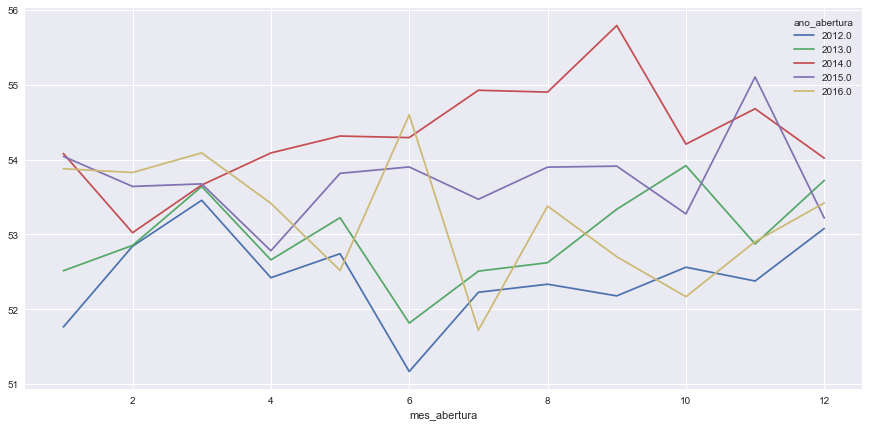

In [15]:
## Existe alguma diferença de reclamações por causa do sexo? 
## Aparentemente, o sexo Feminino 
agrupado_M = df_resultado[(df_resultado['sexo'] == 'M') & (df_resultado['ano_abertura'] >= 2012)].groupby([ 'mes_abertura','ano_abertura'])['razao'].count().unstack()
agrupado_F = df_resultado[(df_resultado['sexo'] == 'F') & (df_resultado['ano_abertura'] >= 2012)].groupby([ 'mes_abertura','ano_abertura'])['razao'].count().unstack()
sexo = agrupado_F/(agrupado_M + agrupado_F) * 100
print('Sexo feminino apresenta ',sexo.mean().mean(),'% das reclamações')
sexo.plot(figsize=(15,7))

A taxa média de atendimento é de  65.24996413700093 % das reclamações


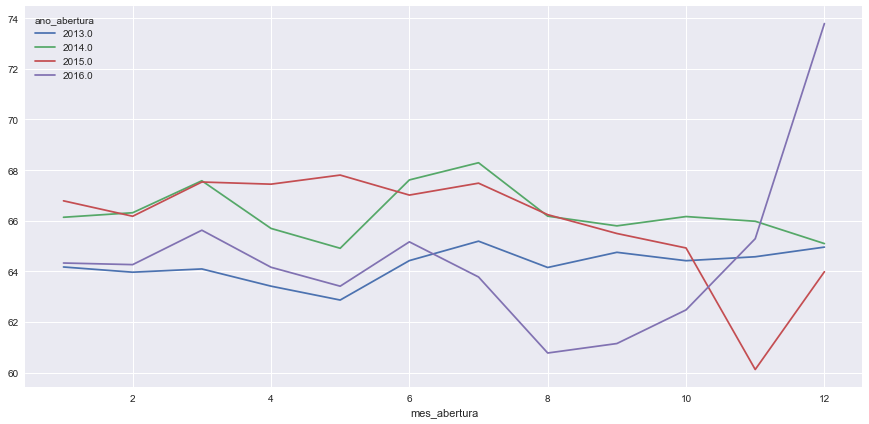

In [16]:
agrupado_S = df_resultado[(df_resultado['Atendida'] == 'S') & (df_resultado['ano_abertura'] >= 2013)].groupby([ 'mes_abertura','ano_abertura'])['razao'].count().unstack()
agrupado_N = df_resultado[(df_resultado['Atendida'] == 'N') & (df_resultado['ano_abertura'] >= 2013)].groupby([ 'mes_abertura','ano_abertura'])['razao'].count().unstack()
atendida = agrupado_S/(agrupado_S + agrupado_N) * 100
print('A taxa média de atendimento é de ',atendida.mean().mean(),'% das reclamações')
atendida.plot(figsize=(15,7))
## As reclamações abertas em Junho/Julho possivelmente possuem taxa de atendimento ligeiramente maior que a média. 

## Passo 04 - Desenhando os gráficos

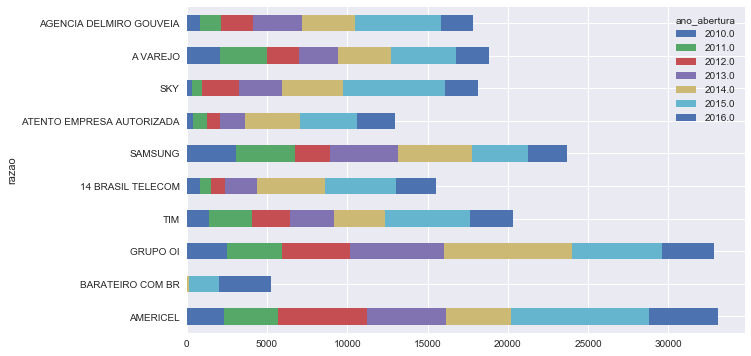

In [17]:
piores_empresas.head(10).plot.barh(figsize=size, stacked=True)

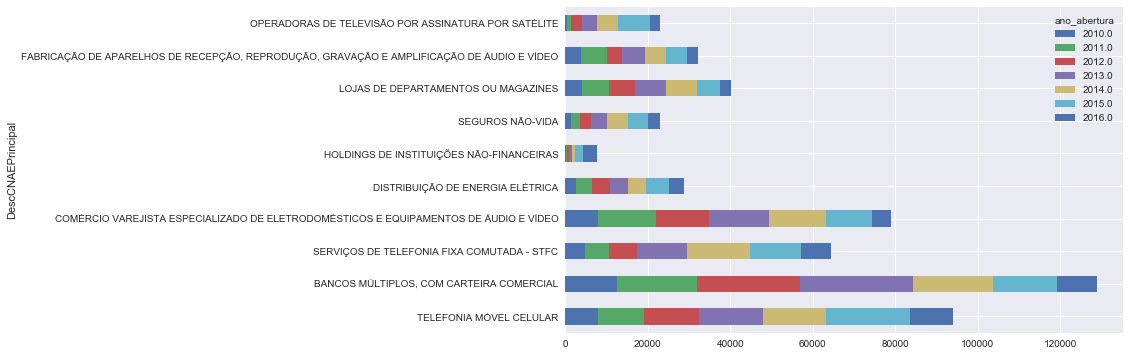

In [19]:
piores_setores = df_resultado.groupby(['DescCNAEPrincipal','ano_abertura'])['razao'].count().unstack()
piores_setores = piores_setores.sort_values(by=[2016,2015], ascending=False).head(100)
piores_setores.drop(columns=range(2005,2010), inplace=True)
piores_setores.head(10)
piores_setores.head(10).plot.barh(figsize=size, stacked=True)

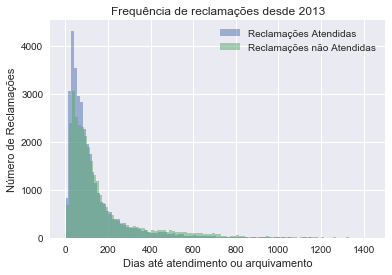

In [20]:
values_atendido   = df_resultado[(df_resultado['ano_abertura'] >= 2013) & 
                                 (df_resultado['atendimento_bin'] == 1)].groupby('razao')['diff'].mean().sort_values(
    ascending=False)
values_atendido = values_atendido[values_atendido > 0]

values_n_atendido = df_resultado[(df_resultado['ano_abertura'] >= 2013) & 
                                 (df_resultado['atendimento_bin'] == 0)].groupby('razao')['diff'].mean().sort_values(
    ascending=False)
values_n_atendido = values_n_atendido[values_n_atendido > 0]

plt.hist(values_atendido, 100, alpha=0.5, label='Reclamações Atendidas')
plt.hist(values_n_atendido, 100, alpha=0.5, label='Reclamações não Atendidas')
plt.xlabel("Dias até atendimento ou arquivamento")
plt.ylabel("Número de Reclamações")
plt.title('Frequência de reclamações desde 2013')
plt.legend(loc='upper right')
plt.show()

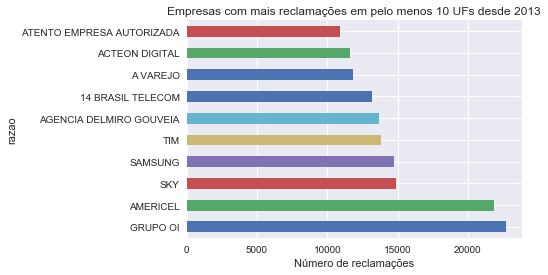

In [21]:
empresas_por_uf = df_resultado[df_resultado.ano_abertura >= 2013].groupby(['razao','UF'])['razao'].count().unstack()
empresas_por_uf.dropna(thresh=10, inplace=True)
empresas_por_uf['total'] = empresas_por_uf.sum(axis=1)
empresas_por_uf.sort_values('total', ascending=False, inplace=True)

plt.xlabel("Número de reclamações")
plt.ylabel("Empresas mais reclamadas")
plt.title('Empresas com mais reclamações em pelo menos 10 UFs desde 2013')
empresas_por_uf['total'].head(10).plot.barh()
plt.show()

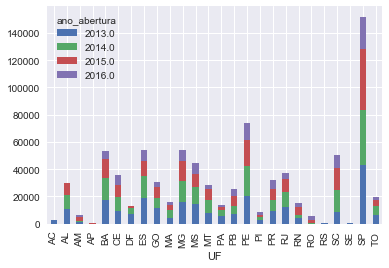

In [22]:
reclama_uf = df_resultado[df_resultado.ano_abertura >= 2013].groupby(['UF','ano_abertura'])['razao'].count().unstack()
reclama_uf.plot.bar(stacked=True)
## Devido ao baixo número de reclamações de AP, RS e SE, supeita-se que não há informações para essas UFs.
## UFs x Número de Reclamações, Reclamações por UF desde 2013

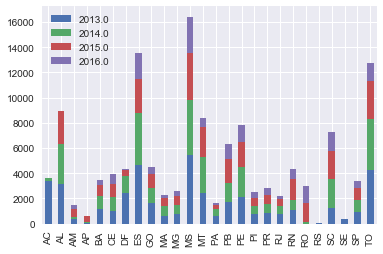

In [23]:
reclama_uf_pop = pd.merge(reclama_uf,pop,left_index=True,right_index=True)
for i in range(2013,2017):
    reclama_uf_pop[i] = reclama_uf_pop[i] / reclama_uf_pop[0] * 1000000
reclama_uf_pop.drop(columns=[0], inplace=True)
reclama_uf_pop.plot.bar(stacked=True)
## UFs x Número de Reclamações por 1.000.000 hab, Reclamações por UF desde 2013